# 09. PyTorch Paper Replicating Exercises

Welcome to the 09. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e1c23f22450>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

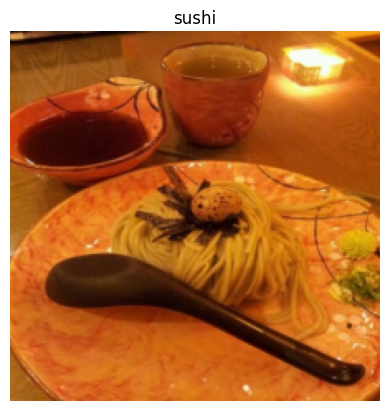

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [10]:
vit = torchvision.models.vit_b_16()

summary(
    model=vit,
    input_size=(32,3,224,224), # batch_size, color_channels, height, width
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [11]:
vit.conv_proj

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [12]:
image.shape

torch.Size([3, 224, 224])

In [13]:
img = torch.randn((32,3,224,224))

In [14]:
patch_size = 16
conv = torch.nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)
out = conv(img)
out.shape

torch.Size([32, 768, 14, 14])

In [15]:
flat = torch.nn.Flatten(start_dim=2)
out = flat(out).permute(0,2,1)
out.shape

torch.Size([32, 196, 768])

In [16]:
class_emb = torch.nn.Parameter(
    torch.randn(32,1,768),
    requires_grad=True,
)
class_emb.shape
out = torch.cat((out,class_emb),dim=1)
out.shape

torch.Size([32, 197, 768])

In [17]:
num_patches = ((IMG_SIZE*IMG_SIZE)//(patch_size*patch_size))

position_emb = torch.nn.Parameter(
    torch.randn(32,num_patches+1,768),
    requires_grad=True,
)

out = out + position_emb
out.shape

torch.Size([32, 197, 768])

In [18]:
from torch import nn

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               embedding_dim: int=768,
               patch_size: int=16,
               num_patches: int=196,
               ) -> None:
      super().__init__()

      self.conv2d = nn.Conv2d(
          in_channels=in_channels,
          out_channels=embedding_dim,
          kernel_size=patch_size,
          stride=patch_size,
          padding=0,
      )

      self.flatten = nn.Flatten(
          start_dim=2
      )

      self.class_token = nn.Parameter(
          data=torch.randn(1,1,embedding_dim),
          requires_grad=True,
      )

      self.position_embedding = nn.Parameter(
          data=torch.randn(1,num_patches+1,embedding_dim),
          requires_grad=True,
      )

  def forward(self, x):
    x = self.conv2d(x)
    x = self.flatten(x).permute(0,2,1)
    cls = self.class_token.expand((x.shape[0],-1,-1))
    x = torch.cat((cls,x), dim=1)
    x = self.position_embedding + x
    return x

In [19]:
class ViT(nn.Module):
  def __init__(self,
               in_channels: int=3,
               embedding_dim: int=768,
               patch_size: int=16,
               num_patches: int=196,
               num_heads: int=12,
               encoder_layers: int=12,
               dropout:int=0.1,
               num_classes: int=3,
               mlp_size: int=3072) -> None:
     super().__init__()

     self.patch_embedding = PatchEmbedding(
         in_channels=in_channels,
         embedding_dim=embedding_dim,
         patch_size=patch_size,
         num_patches=num_patches
     )

     self.encoder_layer = nn.TransformerEncoderLayer(
         d_model=embedding_dim,
         dim_feedforward=mlp_size,
         nhead=num_heads,
         activation='gelu',
         batch_first=True,
         norm_first=True,
     )

     self.encoder = nn.TransformerEncoder(
         encoder_layer=self.encoder_layer,
         num_layers=encoder_layers,
     )

     self.dropout = nn.Dropout(p=dropout)

     self.classifier = nn.Linear(
         in_features=embedding_dim,
         out_features=num_classes,
     )

  def forward(self, x):
    x = self.patch_embedding(x)
    x = self.dropout(x)
    x = self.encoder(x)
    cls = x[:,0]
    x = self.classifier(cls)
    return x


## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [20]:
# TODO: your code
%%writefile going_modular/vit.py

from torch import nn

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               embedding_dim: int=768,
               patch_size: int=16,
               num_patches: int=196,
               ) -> None:
      super().__init__()

      self.conv2d = nn.Conv2d(
          in_channels=in_channels,
          out_channels=embedding_dim,
          kernel_size=patch_size,
          stride=patch_size,
          padding=0,
      )

      self.flatten = nn.Flatten(
          start_dim=2
      )

      self.class_token = nn.Parameter(
          data=torch.randn(1,1,embedding_dim),
          requires_grad=True,
      )

      self.position_embedding = nn.Parameter(
          data=torch.randn(1,num_patches+1,embedding_dim),
          requires_grad=True,
      )

  def forward(self, x):
    x = self.conv2d(x)
    x = self.flatten(x).permute(0,2,1)
    cls = self.class_token.expand((x.shape[0],-1,-1))
    x = torch.cat((cls,x), dim=1)
    x = self.position_embedding + x
    return x

class ViT(nn.Module):
  def __init__(self,
               in_channels: int=3,
               embedding_dim: int=768,
               patch_size: int=16,
               num_patches: int=196,
               num_heads: int=12,
               encoder_layers: int=12,
               dropout:int=0.1,
               num_classes: int=3,
               mlp_size: int=3072) -> None:
     super().__init__()

     self.patch_embedding = PatchEmbedding(
         in_channels=in_channels,
         embedding_dim=embedding_dim,
         patch_size=patch_size,
         num_patches=num_patches
     )

     self.encoder_layer = nn.TransformerEncoderLayer(
         d_model=embedding_dim,
         dim_feedforward=mlp_size,
         nhead=num_heads,
         activation='gelu',
         batch_first=True,
         norm_first=True,
     )

     self.encoder = nn.TransformerEncoder(
         encoder_layer=self.encoder_layer,
         num_layers=encoder_layers,
     )

     self.dropout = nn.Dropout(p=dropout)

     self.classifier = nn.Linear(
         in_features=embedding_dim,
         out_features=num_classes,
     )

  def forward(self, x):
    x = self.patch_embedding(x)
    x = self.dropout(x)
    x = self.encoder(x)
    cls = x[:,0]
    x = self.classifier(cls)
    return x


Overwriting going_modular/vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [21]:
# TODO: your code
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [22]:
from pathlib import Path

train_dir_20_percent, test_dir_20_percent = data_20_percent_path/'train', data_20_percent_path/'test'
train_dir_20_percent, test_dir_20_percent

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [23]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_weights

ViT_B_16_Weights.IMAGENET1K_V1

In [24]:
vit_transforms = vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
from going_modular.going_modular.data_setup import create_dataloaders

train_dataloader_20, test_dataloader_20, class_names = create_dataloaders(
    train_dir = train_dir_20_percent,
    test_dir = test_dir_20_percent,
    transform = vit_transforms,
    batch_size = 32
)

train_dataloader_20, test_dataloader_20

(<torch.utils.data.dataloader.DataLoader at 0x7e1c14e0cda0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e1c14e0fda0>)

In [26]:
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

for params in pretrained_vit.parameters():
  params.requires_grad = False

In [27]:
embedding_dim = 768

pretrained_vit.heads = nn.Sequential(
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

In [28]:
summary(
    model=pretrained_vit,
    input_size=(32,3,224,224), # batch_size, color_channels, height, width
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [29]:
# Setup optimizer and loss_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.001)

In [30]:
from going_modular.going_modular.engine import train

pretrained_vit_results = train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_20,
    test_dataloader=test_dataloader_20,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5904 | train_acc: 0.8208 | test_loss: 0.2116 | test_acc: 0.9750
Epoch: 2 | train_loss: 0.2278 | train_acc: 0.9500 | test_loss: 0.1275 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1434 | train_acc: 0.9625 | test_loss: 0.0986 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.1238 | train_acc: 0.9688 | test_loss: 0.0834 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1024 | train_acc: 0.9729 | test_loss: 0.0741 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0886 | train_acc: 0.9771 | test_loss: 0.0675 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0794 | train_acc: 0.9792 | test_loss: 0.0651 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0702 | train_acc: 0.9833 | test_loss: 0.0626 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0617 | train_acc: 0.9917 | test_loss: 0.0591 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0638 | train_acc: 0.9938 | test_loss: 0.0583 | test_acc: 0.9812


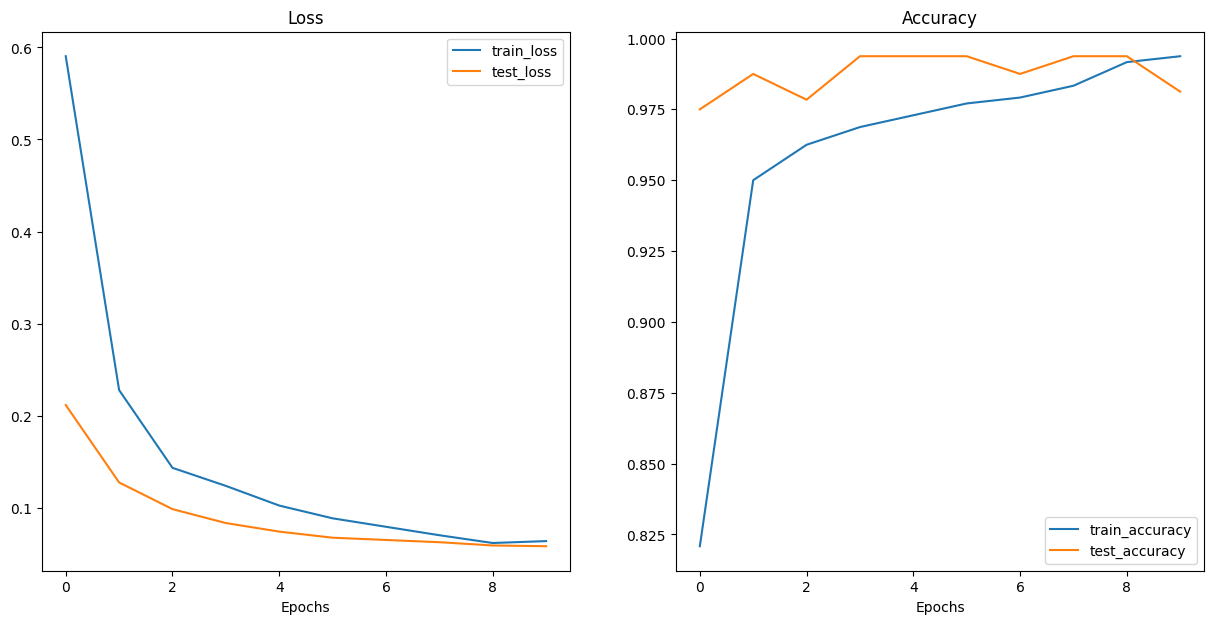

In [31]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [32]:
from going_modular.going_modular.utils import save_model

save_model(
    model=pretrained_vit,
    target_dir='models',
    model_name='ViT_20%_pizza_steak_sushi_10epochs.pth'
)

[INFO] Saving model to: models/ViT_20%_pizza_steak_sushi_10epochs.pth


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [33]:
# TODO: your code
swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
swag_model = torchvision.models.vit_b_16(weights=swag_weights)
swag_transforms = swag_weights.transforms()
swag_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [34]:
train_dataloader_swag, test_dataloader_swag, class_names = create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20_percent,
    transform=swag_transforms,
    batch_size=32
)
train_dataloader_swag, test_dataloader_swag

(<torch.utils.data.dataloader.DataLoader at 0x7e1c14f43d10>,
 <torch.utils.data.dataloader.DataLoader at 0x7e1c14f6dcd0>)

In [35]:
import torch

optimizer = torch.optim.Adam(params=swag_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

swag_results = train(
    train_dataloader=train_dataloader_swag,
    test_dataloader=test_dataloader_swag,
    device=device,
    model=swag_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3241 | train_acc: 0.3563 | test_loss: 1.3701 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.3527 | train_acc: 0.3563 | test_loss: 1.3198 | test_acc: 0.3625
Epoch: 3 | train_loss: 1.2726 | train_acc: 0.3354 | test_loss: 1.1935 | test_acc: 0.3494
Epoch: 4 | train_loss: 1.1929 | train_acc: 0.3917 | test_loss: 1.1891 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.2034 | train_acc: 0.3896 | test_loss: 1.1562 | test_acc: 0.4437
Epoch: 6 | train_loss: 1.1533 | train_acc: 0.4146 | test_loss: 1.1985 | test_acc: 0.3153
Epoch: 7 | train_loss: 1.1409 | train_acc: 0.4167 | test_loss: 1.0500 | test_acc: 0.4023
Epoch: 8 | train_loss: 1.1126 | train_acc: 0.3750 | test_loss: 1.0196 | test_acc: 0.4750
Epoch: 9 | train_loss: 1.0636 | train_acc: 0.4542 | test_loss: 1.3061 | test_acc: 0.2875
Epoch: 10 | train_loss: 1.0927 | train_acc: 0.4479 | test_loss: 1.0381 | test_acc: 0.4562


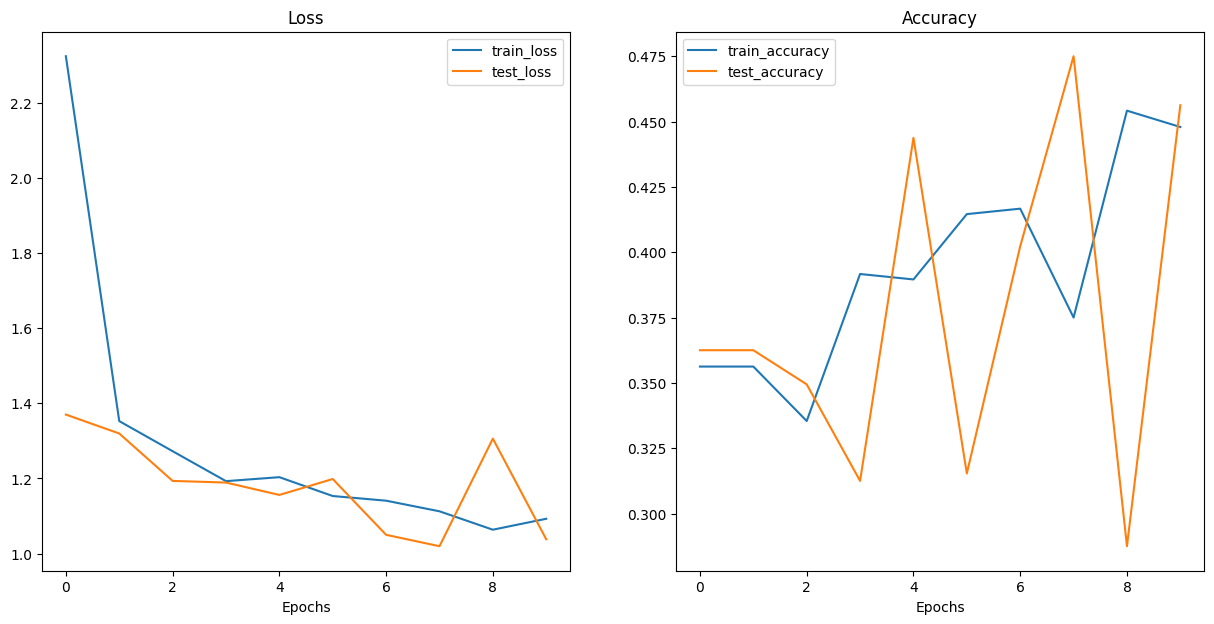

In [37]:
plot_loss_curves(swag_results)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

Pretraining is the process of training the model from scratch. That is, when all the weights and biases of the model are totally random and they are trained from that point to where the model performance pateaus.

In the ViT paper case, they either pretrained with the 300M image JIT or 21k image ImageNet21k datasets, before they fine tuned it for their tasks such as running bench marks on ImageNet and other existing datasets.

This pretraining done on large large image dataset ensure that the transformer could learn the features of what the want it to predict, this is also explicitly stated on the paper that with more data the ViT performs better.

Learning Rate Warmup refers to a technique where during pretraining from scratch the learning rate is first set to low value and then it increases over the period of time gradually during the training steps, until the end of warmup. After which the LR follows the specified decay algorithm

Learning rate Decay refers to the algorithm which programatically reduces the learning rate (The parameters that determines how the weight and bias parameters of a model adjusts themselves after a back propogation) when the model nears a stage of plateau or covergence to steadily increase model performance and avoid overshooting any optimal point in the gradient descent.

Gradient clipping is a technique used in ML to primarily solve the exploding gradients problem. This is when the gradients calculated for the model parameters happen to be super large and the updates to the parameters also become large.

If the parameters keep increasing (or decreasing), then they reach a max value and might overflow, which will cause undesirable behaviour. In general if the parameters get to big, or their updates get too big, the model would oscilate instead of converging (unstable) and it risks overfitting.

Gradient clipping is put in place so that when the calculated gradients of a parameter is above desired value (learned from the data we have for training), we then reduce the scale of the parameter update to ensure the parameters don't end up very big or very small hence helping with convergence.